- Author (except cells that contain prompt): Amirhossein Kiani

In [ ]:
# prompt: give me a code that connects to my drive

from google.colab import drive
drive.mount('/content/drive')


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import json
import geopandas as gpd
from shapely.wkt import loads
from pyproj import Proj, Transformer
from tqdm import tqdm

In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd

data = pd.read_csv("20181024_d1_0830_0900_segmented_oneaxistrajectory_cell.csv")

In [2]:
pd.read_csv("20181024_d1_0830_0900.csv")

,track_id; type; traveled_d; avg_speed; lat; lon; speed; lon_acc; lat_acc; time
0,1; Car; 48.85; 9.770344; 37.977391; 23.737688;...
1,2; Motorcycle; 98.09; 19.839417; 37.977642; 23...
2,3; Motorcycle; 63.80; 18.228752; 37.977997; 23...
3,4; Motorcycle; 145.72; 26.229014; 37.978135; 2...
4,5; Motorcycle; 138.01; 24.841425; 37.978134; 2...
...,...
917,918; Car; 78.83; 30.846243; 37.980629; 23.7350...
918,919; Motorcycle; 19.50; 9.234518; 37.979327; 2...
919,920; Car; 48.97; 24.486209; 37.978413; 23.7355...
920,921; Motorcycle; 46.68; 30.007124; 37.980020; ...


In [ ]:
data

In [ ]:
import json
traffic_light_states_path = "20181024_d1_0830_0900_traffic_light_states.json"
with open(traffic_light_states_path, "r") as f:
  traffic_light_states = json.load(f)

In [ ]:
grouped = data.groupby('time')
grouped_dict = {}
for time, group in grouped:
  grouped_dict[time] = group
from os import times
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')

import hashlib
max_link_id = data["link_id"].values.max()
max_cell_id = {link_id:pd.to_numeric(data[data["link_id"] == link_id]["closest_cell"].str.extract(r'(\d+)')[0], errors='coerce').max() for link_id in data["link_id"].unique()}
first_df = grouped_dict[list(grouped_dict.keys())[0]]

def color_finder_link(link_id):
    # Convert hash to an integer
    return link_id / max_link_id  # Normalize to range [0,1]

def color_finder_cell(cell_id, link_id):
  cell_id = int(cell_id.split("_")[1])
  return cell_id / max_cell_id[link_id]  # Normalize to range [0,1]

fig = plt.figure(figsize=(12, 8))

# Create GridSpec to control layout
gs = fig.add_gridspec(2, 2, height_ratios=[1, 5])  # 1 row for legend, 5 for plots

# Create legend axis spanning both columns
legend_ax = fig.add_subplot(gs[0, :])  # Full-width top row

# Create the main plots below
ax = fig.add_subplot(gs[1, 0])  # Left plot
ax2 = fig.add_subplot(gs[1, 1])  # Right plot

scatter = ax.scatter([], [], c=[], s=20, cmap="twilight", edgecolor="k", vmin=0, vmax=1)
scatter2 = ax2.scatter([], [], c=[], s=20, cmap="twilight", edgecolor="k", vmin=0, vmax=1)
x_min = min(first_df["lon"].values)
x_max = max(first_df["lon"].values)
y_min = min(first_df["lat"].values)
y_max = min(first_df["lat"].values)
ax.axis([x_min-0.0025, x_max + 0.0025, y_min-0.0025, y_max+0.008])
ax2.axis([x_min-0.0025, x_max + 0.0025, y_min-0.0025, y_max+0.008])


# Traffic Light Indicator Positions
traffic_light_labels = ["1", "2", "3", "4"]
traffic_light_positions = np.linspace(0.2, 0.8, 4)  # Evenly spaced

# Create traffic light legend (scatter plot)
traffic_light_legend = legend_ax.scatter(
    traffic_light_positions, [0.5] * 4,  # Fixed y-position
    s=200, edgecolor="black", zorder=3
)
traffic_light_labels = list(traffic_light_states.keys())
# Add Text Labels
# for i, (pos, label) in enumerate(zip(traffic_light_positions, traffic_light_labels)):
#     legend_ax.text(pos, 0.7, label, ha="center", fontsize=12, fontweight="bold")

# Hide axes for cleaner display
legend_ax.set_xticks([])
legend_ax.set_yticks([])
legend_ax.set_frame_on(False)



# Function to generate random data
def generate_data(frame):
    timestamp = list(grouped_dict.keys())[frame]

    dataframe = grouped_dict[timestamp]
    x = dataframe["lon"].values
    y = dataframe["lat"].values
    colors = [color_finder_cell(row["closest_cell"], row["link_id"]) for index, row in dataframe[["closest_cell", "link_id"]].iterrows()]
    colors2 = [color_finder_link(link_id) for link_id in dataframe["link_id"].values]
    fig.suptitle(f"Time: {timestamp}", fontsize=16)

    tl_states = [traffic_light_states[tl][str(timestamp)] for tl in traffic_light_labels]

    return x, y, colors, colors2, tl_states

# Animation update function
def update(frame):
    x, y, colors, colors2, tl_states = generate_data(frame)
    # print(x, y)
    scatter.set_offsets(np.column_stack((x, y)))
    scatter2.set_offsets(np.column_stack((x, y)))
    scatter.set_array(colors)
    scatter2.set_array(colors2)


    # Traffic Light Colors Mapping
    color_map = {"red": "red", "yellow": "yellow", "green": "lime"}
    tl_colors = [color_map[state] for state in tl_states]

    # Update legend colors dynamically
    traffic_light_legend.set_color(tl_colors)


    if frame % 100 == 0:
      pass
      # print(f"Frame: {frame}")
    return scatter, scatter2



ani = animation.FuncAnimation(fig, update, frames=range(0, 13000, 10), interval=100, blit=False)
ax.grid()
ax.set_title("Based on Cell ID")
ax2.grid()
ax2.set_title("Based on Link ID")
ani.save("first_animation.gif", writer="pillow")

Things that should be done here now: Vehicles that do not move for more than a threshold of a time, they should be removed (These are the vehicles that are just stopped there). Vehicles that are in the network for a short period of time should be removed (These are the vehicels that are on the minor roads).

## Removing stopped vehicles for a long time

In [ ]:
modified_data = data.copy()
modified_data["stopped"] = modified_data["speed"] <0.5

In [ ]:
print(modified_data["stopped"].shape)

In [ ]:
# prompt: modified_data["stopped"] is either true or false. If a vehicles is stopped more than 50 seconds (THRESHOLD) I want it all rows for tat amount of time to be eliminated

THRESHOLD = 25  # seconds

# Group by 'veh_id' and 'link_id'
grouped_vehicles = modified_data.groupby(['veh_id', 'link_id'])

# Initialize an empty list to store the indices of rows to remove
indices_to_remove = []

for (veh_id, link_id), group in grouped_vehicles:
    # Find consecutive stopped periods
    stopped_periods = []
    current_period_start = None
    for index, row in group.iterrows():
        if row['stopped']:
            if current_period_start is None:
                current_period_start = index
        elif current_period_start is not None:
            stopped_periods.append((current_period_start, index - 1))  # Store the start and end indices
            current_period_start = None
    if current_period_start is not None:
        stopped_periods.append((current_period_start, group.index[-1])) # Handling case where vehicle is stopped at end of its trajectory

    # Identify and store indices of long stopped periods to remove
    for start_index, end_index in stopped_periods:
        duration = (group.loc[end_index, 'time'] - group.loc[start_index, 'time'])
        if duration > THRESHOLD:
            indices_to_remove.extend(range(start_index, end_index+1))

# Remove the identified rows from the DataFrame
# modified_data = modified_data.drop(index=indices_to_remove)


In [ ]:
remvoed_long_stopped_data = modified_data.drop(index=indices_to_remove)

In [ ]:
print(remvoed_long_stopped_data.shape, modified_data.shape)

## Remove vehilces that appear on minor road

In [ ]:
import numpy as np

def calculate_bearing(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    delta_lon = lon2 - lon1

    x = np.sin(delta_lon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(delta_lon)

    bearing = np.degrees(np.arctan2(x, y))
    return (bearing + 360) % 360

# Example:
lat1, lon1 = 44.9727, -93.2354  # Point 1
lat2, lon2 = 44.9730, -93.2360  # Point 2
direction = calculate_bearing(lat1, lon1, lat2, lon2)
print(f"Bearing: {direction:.2f}°")

In [ ]:
fully_modified_data = remvoed_long_stopped_data.copy().sort_values(by=["veh_id", "time"])
fully_modified_data[["lat_shifted", "shifted_lon", "veh_id_shifted"]] = fully_modified_data.shift(1)[["lat", "lon", "veh_id"]]
bearings = []

for index, row in fully_modified_data.iterrows():
  bearing = 0
  if row["veh_id"] == row["veh_id_shifted"]:
    bearing = calculate_bearing(row["lat"], row["lon"], row["lat_shifted"], row["shifted_lon"])
  bearings.append(bearing)
fully_modified_data["bearing"] = bearings

In [ ]:
grouped = fully_modified_data.groupby("veh_id")
for name, group in grouped:
  bearing_without_zero = group[group["bearing"] != 0]["bearing"]

  print(bearing_without_zero.mean(), name)

In [ ]:
veh_df = fully_modified_data[fully_modified_data["veh_id"] == 884]
plt.plot(veh_df["lat"], veh_df["lon"])

## Filtering with bearing

In [ ]:
fully_modified_data_without_zeros = fully_modified_data[fully_modified_data["bearing"] != 0]
mean_bearings = fully_modified_data_without_zeros.groupby("link_id")["bearing"].mean()
fully_modified_data_temp = fully_modified_data[
    fully_modified_data.apply(
        lambda x: ((x["bearing"] / mean_bearings[x["link_id"]]) <= 1.5 and
                  (x["bearing"] / mean_bearings[x["link_id"]]) >= 0.7) or
                  (x["bearing"] == 0.0),
        axis=1
    )
]
fully_modified_data_temp

In [ ]:
grouped = fully_modified_data_temp.groupby("veh_id")
for name, group in grouped:
  bearing_without_zero = group[group["bearing"] != 0]["bearing"]
  print(bearing_without_zero.mean(), name)

## Filter with the slope sign

In [ ]:
from sklearn.linear_model import LinearRegression

veh_ids_to_be_removed = []

for veh_id, group in fully_modified_data_temp.groupby("veh_id"):
  model = LinearRegression()
  model.fit(group["lat"].values.reshape(-1, 1), group["lon"])
  slope = model.coef_[0]
  if slope > 0:
    veh_ids_to_be_removed.append(veh_id)


In [ ]:
fully_modified_data_temp = fully_modified_data_temp[~fully_modified_data_temp["veh_id"].isin(veh_ids_to_be_removed)]

In [ ]:
summation = fully_modified_data_temp.groupby("veh_id")['bearing'].sum().reset_index()
ans = summation[summation["bearing"] == 0]
filtered_df = fully_modified_data_temp[~fully_modified_data_temp["veh_id"].isin(ans["veh_id"].values)]

# Recreating the animation

In [ ]:
grouped = filtered_df.groupby('time')
grouped_dict = {}
for time, group in grouped:
  grouped_dict[time] = group
from os import times
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')

import hashlib
max_link_id = filtered_df["link_id"].values.max()
max_cell_id = {link_id:pd.to_numeric(filtered_df[filtered_df["link_id"] == link_id]["closest_cell"].str.extract(r'(\d+)')[0], errors='coerce').max() for link_id in filtered_df["link_id"].unique()}
first_df = grouped_dict[list(grouped_dict.keys())[0]]

def color_finder_link(link_id):
    # Convert hash to an integer
    return link_id / max_link_id  # Normalize to range [0,1]

def color_finder_cell(cell_id, link_id):
  cell_id = int(cell_id.split("_")[1])
  return cell_id / max_cell_id[link_id]  # Normalize to range [0,1]

fig = plt.figure(figsize=(12, 8))

# Create GridSpec to control layout
gs = fig.add_gridspec(2, 2, height_ratios=[1, 5])  # 1 row for legend, 5 for plots

# Create legend axis spanning both columns
legend_ax = fig.add_subplot(gs[0, :])  # Full-width top row

# Create the main plots below
ax = fig.add_subplot(gs[1, 0])  # Left plot
ax2 = fig.add_subplot(gs[1, 1])  # Right plot

scatter = ax.scatter([], [], c=[], s=20, cmap="twilight", edgecolor="k", vmin=0, vmax=1)
scatter2 = ax2.scatter([], [], c=[], s=20, cmap="twilight", edgecolor="k", vmin=0, vmax=1)
x_min = min(first_df["lon"].values)
x_max = max(first_df["lon"].values)
y_min = min(first_df["lat"].values)
y_max = min(first_df["lat"].values)
ax.axis([x_min-0.0025, x_max + 0.0025, y_min-0.0025, y_max+0.008])
ax2.axis([x_min-0.0025, x_max + 0.0025, y_min-0.0025, y_max+0.008])


# Traffic Light Indicator Positions
traffic_light_labels = ["1", "2", "3", "4"]
traffic_light_positions = np.linspace(0.2, 0.8, 4)  # Evenly spaced

# Create traffic light legend (scatter plot)
traffic_light_legend = legend_ax.scatter(
    traffic_light_positions, [0.5] * 4,  # Fixed y-position
    s=200, edgecolor="black", zorder=3
)
traffic_light_labels = list(traffic_light_states.keys())
# Add Text Labels
# for i, (pos, label) in enumerate(zip(traffic_light_positions, traffic_light_labels)):
#     legend_ax.text(pos, 0.7, label, ha="center", fontsize=12, fontweight="bold")

# Hide axes for cleaner display
legend_ax.set_xticks([])
legend_ax.set_yticks([])
legend_ax.set_frame_on(False)



# Function to generate random data
def generate_data(frame):
    timestamp = list(grouped_dict.keys())[frame]

    dataframe = grouped_dict[timestamp]
    x = dataframe["lon"].values
    y = dataframe["lat"].values
    colors = [color_finder_cell(row["closest_cell"], row["link_id"]) for index, row in dataframe[["closest_cell", "link_id"]].iterrows()]
    colors2 = [color_finder_link(link_id) for link_id in dataframe["link_id"].values]
    fig.suptitle(f"Time: {timestamp}", fontsize=16)

    tl_states = [traffic_light_states[tl][str(timestamp)] for tl in traffic_light_labels]

    return x, y, colors, colors2, tl_states

# Animation update function
def update(frame):
    x, y, colors, colors2, tl_states = generate_data(frame)
    # print(x, y)
    scatter.set_offsets(np.column_stack((x, y)))
    scatter2.set_offsets(np.column_stack((x, y)))
    scatter.set_array(colors)
    scatter2.set_array(colors2)


    # Traffic Light Colors Mapping
    color_map = {"red": "red", "yellow": "yellow", "green": "lime"}
    tl_colors = [color_map[state] for state in tl_states]

    # Update legend colors dynamically
    traffic_light_legend.set_color(tl_colors)


    if frame % 100 == 0:
      pass
      # print(f"Frame: {frame}")
    return scatter, scatter2



ani = animation.FuncAnimation(fig, update, frames=range(0, 13000, 10), interval=100, blit=False)
ax.grid()
ax.set_title("Based on Cell ID")
ax2.grid()
ax2.set_title("Based on Link ID")
ani.save("second_animation.gif", writer="pillow")

# Animations

## Before cleaning the data

In [ ]:
from IPython.display import display, Image

display(Image(filename="first_animation.gif"))


## After cleaning data

In [ ]:
display(Image(filename="second_animation.gif"))

Although the data was rather fine, but now we have a more clean data!

In [ ]:
filtered_df.to_csv("20181024_d1_0830_0900_segmented_oneaxistrajectory_cell_filtered.csv")

## Finding the denstiy

### Basic density (without considering the length of the car)

In [ ]:
from shapely.wkt import loads
segments_gdf_exploded = pd.read_csv("20181024_d1_0830_0900_segments_gdf_exploded.csv")
segments_gdf_exploded["geometry"] = segments_gdf_exploded["geometry"].apply(loads)
for column in segments_gdf_exploded.columns[segments_gdf_exploded.columns.str.contains("cell_")]:
  segments_gdf_exploded[column] = segments_gdf_exploded[column].apply(lambda x: loads(x) if pd.notna(x) else None)
segments_gdf_exploded

In [ ]:
from geopy.distance import geodesic


veh_counts = filtered_df.groupby(["time", "link_id","closest_cell"]).size().reset_index(name="count")
segments_gdf_exploded_lengths = segments_gdf_exploded.copy()

def get_cell_length_meters(line_string):
  pt1 = line_string.coords[0]
  pt2 = line_string.coords[-1]
  return geodesic(pt1, pt2).meters

for index, row in segments_gdf_exploded_lengths.iterrows():
  for column in segments_gdf_exploded_lengths.columns[segments_gdf_exploded_lengths.columns.str.contains("cell_")]:
    if row[column] is not None:
      segments_gdf_exploded_lengths.at[index, column] = get_cell_length_meters(row[column])

densities = []


for index, row in veh_counts.iterrows():
  cell_id = row["closest_cell"]
  link_id = row["link_id"]
  count = row["count"]
  cell_length = segments_gdf_exploded_lengths[segments_gdf_exploded_lengths["link_id"] == link_id][cell_id].iloc[0]
  density = count/cell_length
  densities.append(density)

veh_counts["density"] = densities

In [ ]:
veh_counts

In [ ]:
veh_counts.to_csv("20181024_d1_0830_0900_veh_counts.csv")

In [ ]:
veh_list = filtered_df.groupby(["time", "link_id", "closest_cell"])["veh_id"].agg(list).reset_index(name="veh_ids")
veh_list = veh_list.sort_values(by=["link_id", "closest_cell", "time"])
veh_list

In [ ]:
veh_list_with_flow = veh_list.copy()
veh_list_groups = veh_list_with_flow.groupby(["link_id", "closest_cell"])
for name, group in veh_list_groups:
  group["previous_veh_ids"] = group["veh_ids"].shift(1)
  group["previous_veh_ids"] = group["previous_veh_ids"].apply(lambda x: x if isinstance(x, list) else [])

  group["next_veh_ids"] = group["veh_ids"].shift(-1)
  group["next_veh_ids"] = group["next_veh_ids"].apply(lambda x: x if isinstance(x, list) else [])

  group["exit"] = group.apply(lambda x: len(set(x["previous_veh_ids"]) - set(x["veh_ids"])), axis=1)
  group["entry"] = group.apply(lambda x: len(set(x["veh_ids"]) - set(x["next_veh_ids"])), axis=1)

  veh_list_with_flow.loc[group.index, ["previous_veh_ids", "next_veh_ids", "exit", "entry"]] = group[["previous_veh_ids", "next_veh_ids", "exit", "entry"]]


In [ ]:
veh_list_with_flow

In [ ]:
veh_density_flow = veh_list_with_flow.join(
    veh_counts.set_index(["link_id", "closest_cell", "time"])[["density"]],
    on=["link_id", "closest_cell", "time"]
)
veh_density_flow.to_csv("20181024_d1_0830_0900_veh_density_flow.csv")

In [ ]:
import pandas as pd
veh_density_flow = pd.read_csv("20181024_d1_0830_0900_veh_density_flow.csv")
veh_density_flow

# CTM Model

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import geopandas as gpd
from matplotlib import rc
import pickle
from shapely.wkt import loads
import ast


rc('animation', html='jshtml')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Loading the data

In [4]:
veh_density_flow = pd.read_csv("20181024_d1_0830_0900_veh_density_flow.csv")
filtered_df = pd.read_csv("20181024_d1_0830_0900_segmented_oneaxistrajectory_cell_filtered.csv")
traffic_lights_df = pd.read_csv("traffic_lights.csv")
segments_gdf_exploded = pd.read_csv("20181024_d1_0830_0900_segments_gdf_exploded.csv")
with open("traffic_info_dict.pkl", "rb") as f:
    traffic_lights_dict_states = pickle.load(f)

segments_gdf_exploded["geometry"] = segments_gdf_exploded["geometry"].apply(loads)
for column in segments_gdf_exploded.columns[segments_gdf_exploded.columns.str.contains("cell_")]:
  segments_gdf_exploded[column] = segments_gdf_exploded[column].apply(lambda x: loads(x) if pd.notna(x) else None)

Cars that are in the first link but not in the last link

In [16]:
veh_by_link = filtered_df.groupby("link_id")["veh_id"].apply(set)
veh_in_first_not_fourth = veh_by_link[0] - veh_by_link[4]
veh_in_first_and_fourth = veh_by_link[0].intersection( veh_by_link[4])
veh_in_first_and_fourth

{27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 38,
 39,
 40,
 43,
 44,
 46,
 47,
 50,
 64,
 70,
 74,
 76,
 90,
 95,
 97,
 102,
 106,
 110,
 112,
 113,
 115,
 118,
 126,
 127,
 130,
 132,
 136,
 140,
 144,
 146,
 152,
 161,
 162,
 164,
 165,
 167,
 168,
 172,
 174,
 175,
 176,
 179,
 180,
 181,
 182,
 184,
 185,
 186,
 196,
 201,
 202,
 208,
 215,
 217,
 220,
 221,
 223,
 225,
 232,
 233,
 234,
 236,
 239,
 242,
 248,
 251,
 253,
 254,
 255,
 256,
 257,
 258,
 259,
 262,
 263,
 264,
 265,
 266,
 269,
 270,
 271,
 275,
 276,
 285,
 286,
 288,
 290,
 296,
 297,
 298,
 299,
 301,
 303,
 304,
 309,
 310,
 324,
 329,
 330,
 333,
 336,
 340,
 341,
 344,
 345,
 347,
 349,
 350,
 351,
 352,
 353,
 355,
 357,
 364,
 365,
 366,
 367,
 368,
 370,
 371,
 372,
 373,
 374,
 375,
 378,
 379,
 382,
 384,
 385,
 386,
 388,
 392,
 400,
 401,
 402,
 422,
 427,
 428,
 431,
 435,
 437,
 438,
 439,
 444,
 446,
 447,
 449,
 450,
 451,
 457,
 458,
 459,
 461,
 466,
 467,
 469,
 470,
 471,
 472,
 482,
 484,

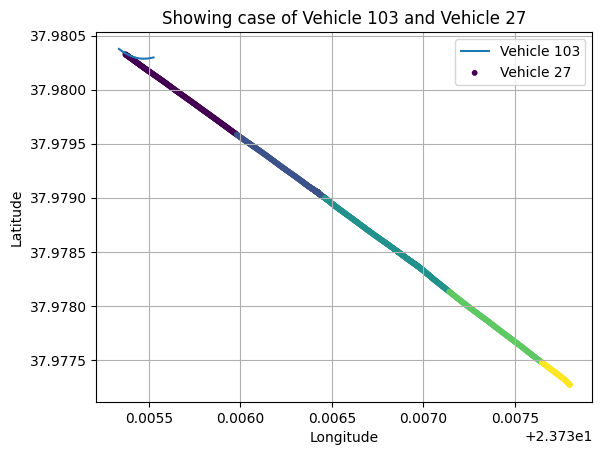

In [26]:
veh_103 = filtered_df[filtered_df["veh_id"] == 103]
plt.plot(veh_103["lon"], veh_103["lat"], label="Vehicle 103")
veh_27 = filtered_df[filtered_df["veh_id"] == 70]
plt.scatter(veh_27["lon"], veh_27["lat"], c=veh_27["link_id"], cmap="viridis", label="Vehicle 27", s=10)
plt.grid()
plt.title("Showing case of Vehicle 103 and Vehicle 27")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()

## Histogram plot

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

speeds = filtered_df['speed']

plt.hist(speeds, bins=20, edgecolor='black')
plt.title("Speed Distribution")
plt.xlabel("Speed (km/h)")
plt.ylabel("Frequency")
plt.grid()
plt.show()

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/eager_project')  # Adjust this path to your module's location

## Importing Mazi's work

# Mazi edited this: added outflow

## Mazi Edited

In [ ]:
from geopy.distance import geodesic


segments_gdf_exploded_lengths = segments_gdf_exploded.copy()

def get_cell_length_meters(line_string):
  pt1 = line_string.coords[0]
  pt2 = line_string.coords[-1]
  return geodesic(pt1, pt2).meters

for index, row in segments_gdf_exploded_lengths.iterrows():
  for column in segments_gdf_exploded_lengths.columns[segments_gdf_exploded_lengths.columns.str.contains("cell_")]:
    if row[column] is not None:
      segments_gdf_exploded_lengths.at[index, column] = get_cell_length_meters(row[column])


# Some functions that will be used as tool, often used.
class CTMParameters:
    def __init__(self, vehicle_length=5, free_flow_speed=15, wave_speed=5, num_lanes=3):
        """
        Initialize the parameters for the Cell Transmission Model.

        Args:
            cell_length (float): Length of each cell (meters).
            free_flow_speed (float): Free flow speed (meters/second).
            wave_speed (float): Backward wave speed (meters/second).
            jam_density (float): Maximum density (vehicles/meter).
        """
        # Default parameter values
        self.num_lanes = num_lanes
        # self.cell_length = cell_length
        self.vehicle_length = vehicle_length
        self.free_flow_speed = free_flow_speed
        self.wave_speed = wave_speed
        # self.jam_density = 150/1000 * cell_length * self.num_lanes
        self.jam_density_link = 130  # jam density for the link: 130 vehicles per km
        self.jam_density_FD = 150 * self.num_lanes # jam density for the road, vehciles per km
        self.max_flow_link = 2000 / 3600 * self.num_lanes # vehicle per seconds


        self.max_flow_link = 2000 / 3600 * self.num_lanes # vehicle per seconds



    def max_flow(self, cell_length):
        """
        Calculate the maximum flow in the system based on the fundamental diagram.

        Returns:
            float: Maximum flow (vehicles/second).
        """
        return min(1800, min(self.free_flow_speed, self.wave_speed) * self.get_jam_density(cell_length) * self.num_lanes)

    def get_time_step(self, cell_length):

    # """
    # Calculate the time step for the simulation.

    # Returns:
    #     float: Time step (seconds).
    # """
        return cell_length / self.free_flow_speed

    def get_jam_density(self, cell_length):
         return 150/1000 * cell_length * self.num_lanes

import math
# Notes for Maziar:
## Do not use CTMParameters().object at all! If you use it, it will create a new object every time you call it. Instead, use the instance that you make of it!
## Try avoidng using the istance of CTMParemeters as a global object. Instead, pass it as an argument to the functions that need it.
## The docstring could be formatted for clarity: 1- Mention all parameters and their expected types! 2- Include an explanation of the function's output!
## Check for invalid or empty densities.
## Use descriptive variable names for better readability.
## Avoid magic numbers like 1 for the green light status; use constants instead.

# ctm_params = CTMParameters() # in this example, we use the default parameters

## Cell transmission model: update cell density
# arguments: densities: list of float + ctm_params: CTMParameters + entry_flow: float (flow of the first cell of the segment which comes from previous segments' outflow)
# " inflow is the number of vehicles enter from the previous cell to the current cell in one step"
# " outflow is the number of vehicles exit from the current cell to the next cell in one step"
# assumptions: jam density and max flow are constant for all cells

cell_lengths = {
  link_id:segments_gdf_exploded_lengths[segments_gdf_exploded_lengths["link_id"] == link_id].iloc[0]["cell_1"] for link_id in segments_gdf_exploded_lengths["link_id"].unique()
}

def update_cell_status(time, segment_id, densities, outflows, ctm_params, entry_flow, traffic_lights_df, traffic_lights_dict_states): # Maz
    num_cells = len(densities)
    new_densities = densities.copy()
    new_outflows = outflows.copy()     # Maz
    cell_length = cell_lengths[segment_id]
    dt = ctm_params.get_time_step(cell_length)
    for i in range(num_cells):  # iterate over all cells
        if i == 0:      # first cell
            inflow = entry_flow # no inflow
        else:           # for all other cells: minimum of max flow and the flow from the previous cell
            inflow = min(ctm_params.max_flow(cell_length), ctm_params.free_flow_speed * densities[i-1] * dt, ctm_params.wave_speed * (ctm_params.get_jam_density(cell_length) - densities[i]) * dt)

        if i == num_cells - 1:  # last cell
            # check if there is a traffic light at the end of the segment
            if is_tl(segment_id, traffic_lights_df):
                # check the status of the traffic light
                if tl_status(time, segment_id, traffic_lights_df, traffic_lights_dict_states) == 1: # green light
                    outflow = min(ctm_params.max_flow(cell_length), ctm_params.free_flow_speed * densities[i] * dt, math.inf)
                    new_outflows[i] = outflow
                else:
                    outflow = 0
                    new_outflows[i] = outflow
            else:
                outflow = min(ctm_params.max_flow(cell_length), ctm_params.free_flow_speed * densities[i] * dt, math.inf)
                new_outflows[i] = outflow # Maz
        else:               # for all other cells: minimum of max flow and the flow to the next cell
            outflow = min(ctm_params.max_flow(cell_length), ctm_params.free_flow_speed * densities[i] * dt, ctm_params.wave_speed * (ctm_params.get_jam_density(cell_length) - densities[i+1]) * dt)
            new_outflows[i] = outflow # Maz
        new_densities[i] = densities[i] + (inflow - outflow) / cell_length   # n(t+1) = n(t) + (y(i) - y(i+1))/dx

    return new_densities, new_outflows # Maz

# test the function
# Density = [0.1, 0.15, 0, 0.2, 0.1, 0.1]
# entry_flow = 0
# time = 5
# updated_density = update_cell_status(time, 1, Density, ctm_params, entry_flow)
# print(updated_density)

def traffic_light(segment_id, time):
    pass # To Kian

# # test the function
# den = [0,0 ,0 , 0, 0]
# print(veh_to_density(den, 20))
# returns whether there is a traffic light at the end of the segment or not
def is_tl(segment_id, traffic_lights_df):
    if segment_id in traffic_lights_df.nearest_link_id.values:
        return True
    return False

# returns status of the traffic light, green = 1, red = 0
# note for Amir: you probably need to add (time, segment id) arguments to this function
def tl_status(time, segment_id, traffic_lights_df, traffic_lights_dict_states):

    # Now lets find the traffic light id in that segment
    if segment_id in traffic_lights_df.nearest_link_id.values:
        tl_id = traffic_lights_df[traffic_lights_df.nearest_link_id == segment_id].index[0]
    # Extract the dataframe out of that dictionary that I made in the ctm_model.ipynb
    traffic_light_status_df = traffic_lights_dict_states[tl_id]
    # Finding the closest time to the given time
    closest_idx = (traffic_light_status_df['time'] - time).abs().idxmin()
    # Getting the status of the traffic light at that time
    status = traffic_light_status_df.loc[closest_idx, 'traffic_status']
    if status == "green":
        return 1
    else:
        return 0

def initialize_density(num_cells, initial_density=0):
    """
    Initialize densities for each cell in the segment.

    Args:
        segment_length (float): Total length of the segment (meters).
        cell_length (float): Length of each cell (meters).
        initial_density (float): Initial density for each cell (vehicles/meter).

    Returns:
        list of float: Initial densities for each cell.
    """
    # Create a list of densities for all cells
    densities = [initial_density] * num_cells
    return densities

def initialize_outflow(num_cells, initial_flow=0):   # Maz
    """
    Initialize densities for each cell in the segment.

    Args:
        segment_length (float): Total length of the segment (meters).
        cell_length (float): Length of each cell (meters).
        initial_density (float): Initial density for each cell (vehicles/meter).

    Returns:
        list of float: Initial densities for each cell.
    """
    # Create a list of densities for all cells
    flows = [initial_flow] * num_cells
    return flows


# Initialize CTM parameters
ctm_params = CTMParameters()
ctm_params.segment_length = segments_gdf_exploded["length"].mean()

## Calculating free flow speed

In [ ]:
import numpy as np
free_flow_threshold = 25
free_flow_speeds = speeds[speeds > free_flow_threshold]

mean_speed = np.mean(free_flow_speeds)
percentile_85 = np.percentile(free_flow_speeds, 85)

print(f"Free Flow Speed (Mean): {mean_speed} km/h")
print(f"Free Flow Speed (85th Percentile): {percentile_85} km/h")
percentile_85_m_s = percentile_85/3.6
ctm_params.free_flow_speed = percentile_85_m_s


## intializing the variables

In [ ]:
def find_traffic_light_id(row, segments_gdf):
    """
    Find the nearest segment ID to a given row in a DataFrame.

    Args:
        row (pd.Series): Row in a DataFrame with columns 'lat' and 'lon'.
        segments_gdf (gpd.GeoDataFrame): GeoDataFrame with segment geometries.

    Returns:
        int: ID of the nearest segment.
    """
    # Create a GeoDataFrame for the point
    point = gpd.GeoDataFrame(
        # Make sure lat and lon is given completely right! Lat first then lon
        geometry=[loads(f"POINT ({row['lat']} {row['lon']})")], crs="EPSG:4326"
    )

    # Reproject both point and segments to a projected CRS for accurate distance calculations
    projected_crs = "EPSG:4326"  # Common projected CRS for distance calculations
    point_proj = point.to_crs(projected_crs)
    segments_gdf_proj = segments_gdf.to_crs(projected_crs)
    max_distance = float("inf")
    nearest_link_id = None
    for index, row in segments_gdf_proj.iterrows():
        distance = row.geometry.distance(point_proj.geometry[0])
        if distance < max_distance:
            max_distance = distance
            nearest_link_id = index
    return nearest_link_id

### Initialization of the density prediction container
segment_densities_predicted = {link_id: initialize_density(
                                                       segments_gdf_exploded[segments_gdf_exploded["link_id"] == link_id].iloc[0, segments_gdf_exploded.columns.str.startswith("cell_")].notna().sum())
                                                       for link_id in segments_gdf_exploded["link_id"].unique()}

### Initialization of the outflow prediction container  Maz
segment_flows_predicted = {link_id: initialize_outflow(
                                                       segments_gdf_exploded[segments_gdf_exploded["link_id"] == link_id].iloc[0, segments_gdf_exploded.columns.str.startswith("cell_")].notna().sum())
                                                       for link_id in segments_gdf_exploded["link_id"].unique()}

# find traffic light segment id
traffic_lights_df["nearest_link_id"] = traffic_lights_df.apply(find_traffic_light_id,
                                                               axis=1,
                                                               segments_gdf=gpd.GeoDataFrame(
                                                                   segments_gdf_exploded,
                                                                   geometry="geometry",
                                                                   crs="EPSG:4326")
                                                               )
traffic_lights_df = traffic_lights_df.iloc[:5, :]


In [ ]:
veh_density_flow[(veh_density_flow["link_id"] == 0) & (veh_density_flow["time"] == 0.12)]


## Running the CTM model

In [ ]:
from tqdm import tqdm
def get_density_for_time(link_id, time, veh_density_flow):
    t0 = time
    density_t0 = veh_density_flow[(veh_density_flow["link_id"] == link_id) & (veh_density_flow["time"] == t0)]
    density_t0_initialized = segment_densities_predicted[link_id].copy()
    for index, row in density_t0.iterrows():
        density_t0_initialized[int(row["closest_cell"].split("_")[-1])-1] = row["density"]

    t1 = t0 + ctm_params.get_time_step(cell_lengths[link_id])

    closest_t1 = veh_density_flow[veh_density_flow["time"] >= t1].sort_values("time")
    if not closest_t1.empty:
        closest_t1 = closest_t1.iloc[0].time
        density_t1 = veh_density_flow[(veh_density_flow["link_id"] == link_id) & (veh_density_flow["time"] ==closest_t1)]
    else:
        density_t1 = pd.DataFrame(columns=["link_id", "time", "closest_cell", "density"])


    density_t1_initialized = segment_densities_predicted[link_id].copy()
    for index, row in density_t1.iterrows():
        density_t1_initialized[int(row["closest_cell"].split("_")[-1])-1] = row["density"]
    density_t1_initialized = np.array(density_t1_initialized)
    density_t0_initialized = np.array(density_t0_initialized)

    return density_t0_initialized, density_t1_initialized


def get_flow_for_time(link_id, time, veh_density_flow):   # function by Maz
    t0 = time
    flow_t0 = veh_density_flow[(veh_density_flow["link_id"] == link_id) & (veh_density_flow["time"] == t0)]

    t1 = t0 + ctm_params.get_time_step(cell_lengths[link_id])

    veh_density_flow[(veh_density_flow["time"] < t1) & (veh_density_flow["time"] >= t0)]
    flow_t0_initialized = segment_flows_predicted[link_id].copy()
    for index, row in flow_t0.iterrows():
        flow_t0_initialized[int(row["closest_cell"].split("_")[-1])-1] = row["exit"]

    t1 = t0 + ctm_params.get_time_step(cell_lengths[link_id])

    closest_t1 = veh_density_flow[veh_density_flow["time"] >= t1].sort_values("time")
    if not closest_t1.empty:
        closest_t1 = closest_t1.iloc[0].time
        flow_t1 = veh_density_flow[(veh_density_flow["link_id"] == link_id) & (veh_density_flow["time"] ==closest_t1)]
    else:
        flow_t1 = pd.DataFrame(columns=["link_id", "time", "closest_cell", "exit"])


    flow_t1_sum = veh_density_flow[(veh_density_flow["link_id"] == link_id) &
                                   (veh_density_flow["time"] >= t0) &
                                   (veh_density_flow["time"] < t1)].groupby("closest_cell")["exit"].sum().reset_index()

    flow_t1_initialized = segment_densities_predicted[link_id].copy()
    for index, row in flow_t1_sum.iterrows():
        flow_t1_initialized[int(row["closest_cell"].split("_")[-1])-1] = row["exit"]

    flow_t1_initialized = np.array(flow_t1_initialized)
    flow_t0_initialized = np.array(flow_t0_initialized)


    return flow_t0_initialized, flow_t1_initialized
actual_values_dict = {}
predicted_values_dict = {}
rmses_dict = {}
times_dict = {}
predict_mean_dict = {}
actual_mean_dict = {}

actual_values_flow_dict = {}
predicted_values_flow_dict = {}
rmses_flow_dict = {}
times_flow_dict = {}
predict_mean_flow_dict = {}
actual_mean_flow_dict = {}

incoming = 0  # maz
turning_ratio = 0.6 # maz
heatmap_data_maz = []

for link_id in veh_density_flow["link_id"].unique():
    rmses = []
    times = []
    predict_mean = []
    actual_mean = []
    predicted_values = []
    actual_values = []

    rmses_flow = [] # maz
    times_flow = []   # maz
    predict_mean_flow = []  # maz
    actual_mean_flow = []    # maz
    predicted_values_flow = []    # maz
    actual_values_flow = []       # maz
    unique_times = veh_density_flow[veh_density_flow["link_id"] == link_id]["time"].unique()
    for unique_time in tqdm(unique_times, unit="time"):
        density_t0_initialized, density_t1_initialized = get_density_for_time(link_id, unique_time, veh_density_flow)
        flow_t0_initialized, flow_t1_initialized = get_flow_for_time(link_id, unique_time, veh_density_flow)     # Maz

        inflow_dt = veh_density_flow[((veh_density_flow["time"] >= unique_time) &
         (veh_density_flow["time"] <= unique_time+ctm_params.get_time_step(cell_lengths[link_id]))) &
          (veh_density_flow["link_id"] == link_id)]

        # print("inflow is " , inflow_dt["entry"].values[0] * ctm_params.time_step)
        if inflow_dt.empty:
            inflow_dt = 0
        else:
            inflow_dt = inflow_dt["entry"].sum() * turning_ratio / ctm_params.get_time_step(cell_lengths[link_id])  # maz

        # heatmap_data_maz.append([link_id, unique_time, inflow_dt])

        predicted_den, predicted_flow = update_cell_status(unique_time, link_id, density_t0_initialized, flow_t0_initialized, ctm_params, inflow_dt, traffic_lights_df, traffic_lights_dict_states)
        predicted_flow  = np.array(predicted_flow)
        predicted_den = np.array(predicted_den)

        predict_mean.append(predicted_den[:].mean())
        predicted_value = predicted_den[:]
        actual_value = density_t1_initialized[:]

        predict_mean_flow.append(predicted_flow[:].mean())   # maz
        predicted_value_flow = predicted_flow[:]        # maz
        actual_value2 = flow_t1_initialized[:]      # maz

        rmse = np.sqrt(np.mean((predicted_value - actual_value)**2))
        predicted_values.append(predicted_value)
        actual_values.append(actual_value)
        actual_mean.append(density_t0_initialized[:].mean())
        rmses.append(rmse)
        times.append(unique_time)

        rmse2 = np.sqrt(np.mean((predicted_value_flow - actual_value2)**2))    # maz
        predicted_values_flow.append(predicted_value_flow)      # maz
        actual_values_flow.append(actual_value2)    # maz
        actual_mean_flow.append(flow_t0_initialized[:].mean())     # maz
        rmses.append(rmse2)    # maz
        times_flow.append(unique_time)    # maz

    actual_values_dict[link_id] = actual_values
    predicted_values_dict[link_id] = predicted_values
    rmses_dict[link_id] = rmses
    times_dict[link_id] = times
    predict_mean_dict[link_id] = predict_mean
    actual_mean_dict[link_id] = actual_mean

    actual_values_flow_dict[link_id] = actual_values_flow    # maz
    predicted_values_flow_dict[link_id] = predicted_values_flow   # maz
    rmses_flow_dict[link_id] = rmses_flow    # maz
    times_flow_dict[link_id] = times_flow     # maz
    predict_mean_flow_dict[link_id] = predict_mean_flow       # maz
    actual_mean_flow_dict[link_id] = actual_mean_flow         # ma

## Saving the results

In [ ]:
import pickle

# Save the dictionaries to a pickle file
with open("ctm_results_Mazi.pkl", "wb") as f:
    pickle.dump({
        "actual_values_dict": actual_values_dict,
        "predicted_values_dict": predicted_values_dict,
        "rmses_dict": rmses_dict,
        "times_dict": times_dict,
        "predict_mean_dict": predict_mean_dict,
        "actual_mean_dict": actual_mean_dict,
        "actual_values_flow_dict": actual_values_flow_dict,
        "predicted_values_flow_dict": predicted_values_flow_dict,
        "rmses_flow_dict": rmses_flow_dict,
        "times_flow_dict": times_flow_dict,
        "predict_mean_flow_dict": predict_mean_flow_dict,
        "actual_mean_flow_dict": actual_mean_flow_dict
    }, f)

print("Dictionaries saved to ctm_results.pkl")


## Loading CTM model

In [ ]:
import pickle

# Load the dictionaries from the pickle file
with open("ctm_results_Mazi.pkl", "rb") as f:
    data = pickle.load(f)

# Extract individual dictionaries
actual_values_dict = data["actual_values_flow_dict"]
predicted_values_dict = data["predicted_values_flow_dict"]
rmses_dict = data["rmses_flow_dict"]
times_dict = data["times_flow_dict"]
predict_mean_dict = data["predict_mean_flow_dict"]
actual_mean_dict = data["actual_mean_flow_dict"]

actual_values_flow_dict = data["actual_values_flow_dict"]
predicted_values_flow_dict = data["predicted_values_flow_dict"]
rmses_flow_dict = data["rmses_flow_dict"]
times_flow_dict = data["times_flow_dict"]
predict_mean_flow_dict = data["predict_mean_flow_dict"]
actual_mean_flow_dict = data["actual_mean_flow_dict"]

print("Dictionaries successfully loaded!")


In [ ]:
from collections import defaultdict



In [ ]:
from collections import defaultdict

import plotly.express as px
import plotly.graph_objects as go

heatmap_data_error = defaultdict(lambda : defaultdict(list))
heatmap_data_actual = defaultdict(lambda : defaultdict(list))
heatmap_data_precicted = defaultdict(lambda : defaultdict(list))

# Maz
heatmap_data_flow_error = defaultdict(lambda : defaultdict(list))
heatmap_data_flow_actual = defaultdict(lambda : defaultdict(list))
heatmap_data_flow_precicted = defaultdict(lambda : defaultdict(list))

min_i = 0
for link_id in times_dict.keys():
    for time_index in range(len(times_dict[link_id])):
        time = times_dict[link_id][time_index]
        a = actual_values_dict[link_id][time_index]
        p = predicted_values_dict[link_id][time_index]
        e2 = abs(a-p)
        heatmap_data_error[link_id][time] = e2
        heatmap_data_actual[link_id][time] = a
        heatmap_data_precicted[link_id][time] = p


        # Maz
        a2 = actual_values_flow_dict[link_id][time_index]
        p2 = predicted_values_flow_dict[link_id][time_index]
        e22 = abs(a-p)
        heatmap_data_flow_error[link_id][time] = e22
        heatmap_data_flow_actual[link_id][time] = a2
        heatmap_data_flow_precicted[link_id][time] = p2

data_list_error = []
data_list_actual = []
data_list_predicted = []

# MAz
data_list_flow_error = []
data_list_flow_actual = []
data_list_flow_predicted = []

for link_id, time_dict in heatmap_data_error.items():
    for time, values in time_dict.items():
        for cell_idx, value in enumerate(values):
            data_list_error.append({"link_id": link_id, "time": time, "cell": cell_idx + 1, "value": value})

for link_id, time_dict in heatmap_data_actual.items():
    for time, values in time_dict.items():
        for cell_idx, value in enumerate(values):
            data_list_actual.append({"link_id": link_id, "time": time, "cell": cell_idx + 1, "value": value})

for link_id, time_dict in heatmap_data_precicted.items():
    for time, values in time_dict.items():
        for cell_idx, value in enumerate(values):
            data_list_predicted.append({"link_id": link_id, "time": time, "cell": cell_idx + 1, "value": value})

# MAz
for link_id, time_dict in heatmap_data_flow_error.items():
    for time, values in time_dict.items():
        for cell_idx, value in enumerate(values):
            data_list_flow_error.append({"link_id": link_id, "time": time, "cell": cell_idx + 1, "value": value})

for link_id, time_dict in heatmap_data_flow_actual.items():
    for time, values in time_dict.items():
        for cell_idx, value in enumerate(values):
            data_list_flow_actual.append({"link_id": link_id, "time": time, "cell": cell_idx + 1, "value": value})

for link_id, time_dict in heatmap_data_flow_precicted.items():
    for time, values in time_dict.items():
        for cell_idx, value in enumerate(values):
            data_list_flow_predicted.append({"link_id": link_id, "time": time, "cell": cell_idx + 1, "value": value})

df_error = pd.DataFrame(data_list_error)
df_actual = pd.DataFrame(data_list_actual)
df_predicted = pd.DataFrame(data_list_predicted)

df_flow_error = pd.DataFrame(data_list_flow_error)
df_flow_actual = pd.DataFrame(data_list_flow_actual)
df_flow_predicted = pd.DataFrame(data_list_flow_predicted)

## CTM Error Heatmap

In [ ]:
min_value = df_flow_error["value"].min()
max_value = df_flow_error["value"].max()
for name, group in df_flow_error.groupby("link_id"):
  group = group[group["cell"] != 1]
  fig = go.Figure(data=go.Heatmap(
      z=group["value"].values,
      x=group["cell"].values,
      y=group["time"].values,
      colorscale="Reds",

  ))
  fig.update_layout(
      title=f"OUTFLOW Error Heatmap - Link ID {name}",  # Dynamic title per link_id
      xaxis_title="Cell Index",
      yaxis_title="Time",
      font=dict(size=14)  # Adjust font size for better readability
  )

  fig.show()

## CTM Actual Heatmap

In [ ]:
min_value = df_flow_actual["value"].min()
max_value = df_flow_actual["value"].max()
for name, group in df_flow_actual.groupby("link_id"):

  fig = go.Figure(data=go.Heatmap(
      z=group["value"].values,
      x=group["cell"].values,
      y=group["time"].values,
      colorscale="Reds",
      zmin=min_value,
      zmax=max_value
  ))
  fig.update_layout(
      title=f"OUTFLOW Actual Heatmap - Link ID {name}",  # Dynamic title per link_id
      xaxis_title="Cell Index",
      yaxis_title="Time",
      font=dict(size=14)  # Adjust font size for better readability
  )

  fig.show()

## CTM Predicted Heatmap

In [ ]:
min_value = df_flow_predicted["value"].min()
max_value = df_flow_predicted["value"].max()
for name, group in df_flow_predicted.groupby("link_id"):

  fig = go.Figure(data=go.Heatmap(
      z=group["value"].values,
      x=group["cell"].values,
      y=group["time"].values,
      colorscale="Reds",
      zmin=min_value,
      zmax=max_value
  ))
  fig.update_layout(
      title=f"Outflow Predicted Heatmap - Link ID {name}",  # Dynamic title per link_id
      xaxis_title="Cell Index",
      yaxis_title="Time",
      font=dict(size=14)  # Adjust font size for better readability
  )

  fig.show()

# Point Queue Model

In [ ]:
df_filtered = pd.read_csv("20181024_d1_0830_0900_segmented_oneaxistrajectory_cell.csv")
veh_density_flow = pd.read_csv("20181024_d1_0830_0900_veh_density_flow.csv")

# grouped_with_veh_ids = df_filtered.groupby(["link_id", "time"]).agg({
#     "veh_id": lambda x: frozenset(x)  # Use frozenset instead of set
# }).reset_index()

# df_filtered = df_filtered.merge(grouped_with_veh_ids, on=["link_id", "time"], suffixes=('', '_list'))
# df_filtered.rename(columns={"veh_id_list": "veh_id_list"}, inplace=True)
# duplicate_dropped = df_filtered.drop_duplicates(subset=["link_id", "time", "veh_id_list"])[["veh_id_list", "link_id", "time"]]
# link_dataframes = {}
# duplicate_dropped.columns = [f"{col}_{i}" if duplicate_dropped.columns.duplicated()[i] else col for i, col in enumerate(duplicate_dropped.columns)]
# for link_id in duplicate_dropped["link_id"].unique():


#     segment_df = duplicate_dropped[duplicate_dropped["link_id"] == link_id].reset_index().drop(columns=["index"])
#     segment_df = segment_df.sort_values("time")

#     segment_df["N_down"] = segment_df["veh_id_list"] - segment_df["veh_id_list"].shift(1)
#     segment_df["N_up"] = segment_df["veh_id_list"].shift(-1) - segment_df["veh_id_list"]

#     segment_df["N_cumsum_down"] = segment_df["N_down"].iloc[1:].apply(len).cumsum()
#     segment_df["N_cumsum_up"] = segment_df["N_up"].iloc[:-1].apply(len).cumsum()

#     link_dataframes[link_id] = segment_df


In [ ]:
veh_density_flow["veh_ids"] = veh_density_flow["veh_ids"].apply(lambda x: ast.literal_eval(x))

In [ ]:
veh_density_flow["count"] = veh_density_flow["veh_ids"].apply(len)

In [ ]:
link_dataframes = {}
duplicate_dropped = veh_density_flow.groupby(["time","link_id"])[["entry", "exit", "count"]].sum().reset_index()
for link_id in duplicate_dropped["link_id"].unique():
  segment_df = duplicate_dropped[duplicate_dropped["link_id"] == link_id].reset_index().drop(columns=["index"])
  segment_df = segment_df.sort_values("time")
  segment_df["N_down"] = segment_df["exit"]
  segment_df["N_up"] = segment_df["entry"]
  segment_df["N_cumsum_down"] = segment_df["N_down"].iloc[1:].cumsum()
  segment_df["N_cumsum_up"] = segment_df["N_up"].iloc[:-1].cumsum()
  link_dataframes[link_id] = segment_df

In [ ]:
import math
def cumulativecount_up(time, link_id):
    segment_df = link_dataframes[link_id]
    closest_time = segment_df[segment_df['time'] <= time].time.max()
    if math.isnan(closest_time):
        return 0
    return segment_df[segment_df['time'] == closest_time]["N_cumsum_up"].values[0]

def cumulativecount_down(time, link_id):
    segment_df = link_dataframes[link_id]
    closest_time = segment_df[segment_df['time'] <= time].time.max()
    if math.isnan(closest_time):
        return 0
    return segment_df[segment_df['time'] == closest_time]["N_cumsum_down"].values[0]
# Notes for Maziar:
## Do not use CTMParameters().object at all! If you use it, it will create a new object every time you call it. Instead, use the instance that you make of it!
## Try avoidng using the istance of CTMParemeters as a global object. Instead, pass it as an argument to the functions that need it.
## The docstring could be formatted for clarity: 1- Mention all parameters and their expected types! 2- Include an explanation of the function's output!
## Check for invalid or empty densities.
## Use descriptive variable names for better readability.
## Avoid magic numbers like 1 for the green light status; use constants instead.


# load params
ctm_params = CTMParameters() # for now, we use same parameters we had in CTM model
segment_length = segments_gdf_exploded["length"].mean()
# define the function for finding cumulative counts
N_upstr = cumulativecount_up
N_downstr = cumulativecount_down

## Cell transmission model: update cell density
# time: current simulation time
# arguments: N_upstrs: cumulative count of vehicles in upstream at a given time. I'll pass N_downstr(t) and it should tell me the cumulative count
# N_downstr: cumulative count at link downstream at time t (current time)
# entry_flow: for now constant, entering to the link in vehicles per second
# assumptions: jam density and max flow are constant for all cells
def update_point_queue(time, link_id, entry_flow, traffic_lights_df, traffic_lights_dict_states):
    cell_length = cell_lengths[link_id]
    segment_length = segments_gdf_exploded[segments_gdf_exploded["link_id"] == link_id].iloc[0].length
    # check if there is a traffic light at the end of the segment
    if is_tl(link_id, traffic_lights_df):
        # check the status of the traffic light
        if tl_status(time, link_id, traffic_lights_df, traffic_lights_dict_states) == 1: # green light
            # find the link sending flow using point queue model
            sending_flow = min( N_upstr(time + ctm_params.get_time_step(cell_length) - (segment_length/ctm_params.free_flow_speed), link_id) - N_downstr(time , link_id), ctm_params.max_flow(cell_length)*ctm_params.get_time_step(cell_length))
        else:
            sending_flow = 0
    else: # no traffic light at the end of the link
        sending_flow = min( N_upstr(time + ctm_params.get_time_step(cell_length) - (segment_length/ctm_params.free_flow_speed), link_id) - N_downstr(time , link_id), ctm_params.max_flow(cell_length)*ctm_params.get_time_step(cell_length))

    # find the number of vehicles in the link at the next time step
    n_current =  N_upstr(time, link_id) - N_downstr(time, link_id)   # current number of vehicles

    n_updated = n_current + entry_flow * ctm_params.get_time_step(cell_length) -  sending_flow
    if n_updated < 0:
        print("n_current", n_current, "sending flow", sending_flow, "entry flow", entry_flow, "time", time)
        print("N DOWNSTR is", N_upstr(time, link_id)  ,"at this time N special is", N_upstr(time + ctm_params.get_time_step(cell_length) - (segment_length/ctm_params.free_flow_speed), link_id))

    link_outflow = sending_flow
    link_density = n_updated / segment_length
    return link_density, link_outflow    # please note the   order ## I will:)


In [ ]:
len(duplicate_dropped[duplicate_dropped["link_id"] == 4].time.unique())

In [ ]:
from collections import defaultdict
from tqdm import tqdm
point_queue_data = defaultdict(dict)

for link_id in duplicate_dropped["link_id"].unique():
    segment_df = duplicate_dropped[duplicate_dropped["link_id"] == link_id].reset_index().drop(columns=["index"])
    segment_df = segment_df.sort_values("time")
    for time in tqdm(segment_df["time"].unique(), unit="time"+f" {link_id}"):

        inflow_dt = veh_density_flow[((veh_density_flow["time"] >= time) &
         (veh_density_flow["time"] <= time+ctm_params.get_time_step(cell_lengths[link_id]))) &
          (veh_density_flow["link_id"] == link_id)]

        # print("inflow is " , inflow_dt["entry"].values[0] * ctm_params.time_step)
        if inflow_dt.empty:
            inflow_dt = 0
        else:
            inflow_dt = inflow_dt["entry"].sum() / ctm_params.get_time_step(cell_lengths[link_id])

        link_density, link_outflow = update_point_queue(time, link_id, inflow_dt, traffic_lights_df, traffic_lights_dict_states)

        point_queue_data[link_id][time] = {"link_density": link_density, "link_outflow": link_outflow}
        # print(time, link_id, "done")
duplicate_dropped["point_queue_predicted_density"] = duplicate_dropped.apply(lambda x: point_queue_data[x["link_id"]][x["time"]]["link_density"], axis=1).fillna(0)

In [ ]:
duplicate_dropped["density"] = duplicate_dropped.reset_index().apply(lambda row: row["count"]/(segments_gdf_exploded[segments_gdf_exploded["link_id"] == row["link_id"]]["length"].values[0]), axis=1)

In [ ]:
for link_id in sorted(duplicate_dropped["link_id"].unique()):
    rmse = np.sqrt(np.mean((duplicate_dropped[duplicate_dropped["link_id"] == link_id]["density"] - duplicate_dropped[duplicate_dropped["link_id"] == link_id]["point_queue_predicted_density"])**2))
    print("For link with id: ", link_id, " the RMSE is: ", rmse)

## Point Queue Heatmap

In [ ]:
import plotly.graph_objects as go
import pandas as pd

duplicate_dropped2 = duplicate_dropped.copy()
duplicate_dropped2["e2"] = (duplicate_dropped2["point_queue_predicted_density"] - duplicate_dropped2["density"])**2

unique_links = duplicate_dropped2["link_id"].unique()
unique_times = duplicate_dropped2["time"].unique()

full_grid = pd.MultiIndex.from_product([unique_links, unique_times], names=["link_id", "time"]).to_frame(index=False)

filled_data = full_grid.merge(duplicate_dropped2, on=["link_id", "time"], how="left").fillna({"e2": 0})

fig = go.Figure(data=go.Heatmap(
    z=filled_data["e2"].values,
    x=filled_data["link_id"].values,
    y=filled_data["time"].values,
    colorscale="Reds",
    zmin=filled_data["e2"].min(),
    zmax=filled_data["e2"].max()
))

fig.update_layout(
    title="Error Heatmap for Point Queue",
    xaxis_title="Cell Index",
    yaxis_title="Time",
    font=dict(size=14),
    coloraxis_colorbar=dict(title="Value")
)

fig.show()


In [ ]:
# prompt: store0 duplicated_dropped dataframe  for point queue

import pandas as pd
import pickle
# Assuming 'duplicate_dropped' DataFrame is already defined and populated as in your provided code

# Save the dataframe to a pickle file
with open("duplicated_dropped_dataframe_pq.pkl", "wb") as f:
    pickle.dump(duplicate_dropped, f)

print("DataFrame saved to duplicated_dropped_dataframe_pq.pkl")


In [ ]:
# prompt: load duplicated_dropped dataframe for point queue

import pickle

# Load the dataframe from the pickle file
with open("duplicated_dropped_dataframe_pq.pkl", "rb") as f:
    duplicate_dropped = pickle.load(f)

print("DataFrame successfully loaded!")


# Spatial Queue

In [ ]:
# from constants import CTMParameters
import math

# Notes for Maziar:
## Do not use CTMParameters().object at all! If you use it, it will create a new object every time you call it. Instead, use the instance that you make of it!
## Try avoidng using the istance of CTMParemeters as a global object. Instead, pass it as an argument to the functions that need it.
## The docstring could be formatted for clarity: 1- Mention all parameters and their expected types! 2- Include an explanation of the function's output!
## Check for invalid or empty densities.
## Use descriptive variable names for better readability.
## Avoid magic numbers like 1 for the green light status; use constants instead.


# load params
ctm_params = CTMParameters() # for now, we use same parameters we had in CTM model

# define the function for finding cumulative counts
N_upstr = cumulativecount_up
N_downstr = cumulativecount_down

## spatial queue model: update number of vehicles in the link
# time: current simulation time
# arguments: N_upstrs: cumulative count of vehicles in upstream at a given time. I'll pass N_downstr(t) and it should tell me the cumulative count
# N_downstr: cumulative count at link downstream at time t (current time)
# entry_flow: for now constant, average number of vehicles entering to the link in vehicles per second
# assumptions: queue forms at the link downstream
def update_spatial_queue(time, link_id, entry_flow, traffic_lights_df, traffic_lights_dict_states):
    cell_length = cell_lengths[link_id]
    segment_length = segments_gdf_exploded[segments_gdf_exploded["link_id"] == link_id].iloc[0].length
    #find the receiving flow, including the entry flow
    receceiving_flow = min( entry_flow*ctm_params.get_time_step(cell_length), segment_length*ctm_params.get_jam_density(cell_length) - (N_upstr(time,link_id) - N_downstr(time,link_id)), ctm_params.max_flow(cell_length)*ctm_params.get_time_step(cell_length))

    # check if there is a traffic light at the end of the segment
    if is_tl(link_id, traffic_lights_df):
        # check the status of the traffic light
        if tl_status(time, link_id, traffic_lights_df, traffic_lights_dict_states) == 1: # green light
            # find the link sending flow using point queue model
            sending_flow = min( N_upstr(time + ctm_params.get_time_step(cell_length) - (segment_length/ctm_params.free_flow_speed), link_id) - N_downstr(time, link_id), ctm_params.max_flow(cell_length)*ctm_params.get_time_step(cell_length))
        else:
            sending_flow = 0
    else: # no traffic light at the end of the link
        sending_flow = min( N_upstr(time + ctm_params.get_time_step(cell_length) - (segment_length/ctm_params.free_flow_speed), link_id) - N_downstr(time, link_id), ctm_params.max_flow(cell_length)*ctm_params.get_time_step(cell_length))

    # find the number of vehicles in the link at the next time step
    n_current = N_downstr(time, link_id) - N_upstr(time, link_id)   # current number of vehicles
    n_updated = n_current + receceiving_flow - sending_flow

    link_outflow = sending_flow
    link_density = n_updated / segment_length
    return link_density, link_outflow    # please note the order

# # test the function
# Density = [0.1, 0.15, 0, 0.2, 0.1, 0.1]
# entry_flow = 0.1
# time = 5
# updated_density = update_point_queue(time, 1, Density, ctm_params, entry_flow)
# print(updated_density)

In [ ]:
from collections import defaultdict

spatial_queue_data = defaultdict(dict)

for link_id in duplicate_dropped["link_id"].unique():
    segment_df = duplicate_dropped[duplicate_dropped["link_id"] == link_id].reset_index().drop(columns=["index"])
    segment_df = segment_df.sort_values("time")
    for time in segment_df["time"].unique():

        inflow_dt = veh_density_flow[((veh_density_flow["time"] >= time) &
         (veh_density_flow["time"] <= time+ctm_params.get_time_step(cell_lengths[link_id]))) &
          (veh_density_flow["link_id"] == link_id)]

        # print("inflow is " , inflow_dt["entry"].values[0] * ctm_params.time_step)
        if inflow_dt.empty:
            inflow_dt = 0
        else:
            inflow_dt = inflow_dt["entry"].sum() / ctm_params.get_time_step(cell_lengths[link_id])

        link_density, link_outflow = update_spatial_queue(time, link_id, inflow_dt, traffic_lights_df, traffic_lights_dict_states)

        spatial_queue_data[link_id][time] = {"link_density": link_density, "link_outflow": link_outflow}
        # print(time, link_id, "done")


In [ ]:
duplicate_dropped["spatial_queue_predicted_density"] = duplicate_dropped.apply(lambda x: spatial_queue_data[x["link_id"]][x["time"]]["link_density"], axis=1).fillna(0)
# duplicate_dropped["density"] = duplicate_dropped.reset_index().apply(lambda row: row["count"]/(segments_gdf_exploded[segments_gdf_exploded["link_id"] == row["link_id"]]["length"].values[0]), axis=1)

In [ ]:
for link_id in sorted(duplicate_dropped["link_id"].unique()):
    rmse = np.sqrt(np.mean((duplicate_dropped[duplicate_dropped["link_id"] == link_id]["density"] - duplicate_dropped[duplicate_dropped["link_id"] == link_id]["spatial_queue_predicted_density"])**2))
    print("For link with id: ", link_id, " the RMSE is: ", rmse)

In [ ]:
# prompt: store0 duplicated_dropped dataframe  for point queue

import pandas as pd
import pickle
# Assuming 'duplicate_dropped' DataFrame is already defined and populated as in your provided code

# Save the dataframe to a pickle file
with open("duplicated_dropped_dataframe_pq_sq.pkl", "wb") as f:
    pickle.dump(duplicate_dropped, f)

print("DataFrame saved to duplicated_dropped_dataframe_pq_sq.pkl")


In [ ]:

# prompt: load duplicated_dropped dataframe for point queue

import pickle

# Load the dataframe from the pickle file
with open("duplicated_dropped_dataframe_pq_sq.pkl", "rb") as f:
    duplicate_dropped = pickle.load(f)

print("DataFrame successfully loaded!")


## Spatial Queue Heatmap

In [ ]:
import plotly.graph_objects as go
duplicate_dropped3 = duplicate_dropped.copy()
duplicate_dropped3["e2"] = (duplicate_dropped3["spatial_queue_predicted_density"] - duplicate_dropped3["density"])**2

unique_links = duplicate_dropped3["link_id"].unique()
unique_times = duplicate_dropped3["time"].unique()

full_grid = pd.MultiIndex.from_product([unique_links, unique_times], names=["link_id", "time"]).to_frame(index=False)

filled_data = full_grid.merge(duplicate_dropped3, on=["link_id", "time"], how="left").fillna({"e2": 0})
fig = go.Figure(data=go.Heatmap(
    z=duplicate_dropped3["e2"].values,
    x=duplicate_dropped3["link_id"].values,
    y=duplicate_dropped3["time"].values,
    colorscale="Reds",
    zmin=duplicate_dropped3["e2"].min(),
    zmax=duplicate_dropped3["e2"].max()
))

fig.update_layout(
    title=f"Error Heatmap for Spatial Queue",
    xaxis_title="Cell Index",
    yaxis_title="Time",
    font=dict(size=14),
    coloraxis_colorbar=dict(title="Value")  # Add colorbar title
)

fig.show()

# Comparison

In [ ]:
ctm_actual = pd.DataFrame(data_list_actual)
ctm_predicted = pd.DataFrame(data_list_predicted)

In [ ]:
ctm_merged = ctm_actual.merge(ctm_predicted, on=["link_id", "cell", "time"], suffixes=('_actual', '_predicted'))
ctm_merged["sq_error"] = (ctm_merged["value_actual"] - ctm_merged["value_predicted"])**2

In [ ]:
ctm_merged_rmse = ctm_merged.groupby(by=["link_id", "cell"]).agg({"sq_error": "mean"}).reset_index()
ctm_merged_rmse["rmse"] = np.sqrt(ctm_merged_rmse["sq_error"])
ctm_merged_rmse

In [ ]:
duplicate_dropped["point_queue_sq_error"] = (duplicate_dropped["point_queue_predicted_density"] - duplicate_dropped["density"])**2
duplicate_dropped["spatial_queue_sq_error"] = (duplicate_dropped["spatial_queue_predicted_density"] - duplicate_dropped["density"])**2

In [ ]:
pq_sq_rmse = duplicate_dropped.groupby("link_id").agg({"point_queue_sq_error": "mean", "spatial_queue_sq_error": "mean"}).reset_index()
pq_sq_rmse["pq_rmse"] = np.sqrt(pq_sq_rmse["point_queue_sq_error"])
pq_sq_rmse["sq_rmse"] = np.sqrt(pq_sq_rmse["spatial_queue_sq_error"])
pq_sq_rmse

## Comparison Plot

In [ ]:
import matplotlib.pyplot as plt
import re
x = ctm_merged_rmse.apply(lambda row: "L" + str(int(row["link_id"])) + "C" + str(int(row["cell"])), axis=1)
y = ctm_merged_rmse["rmse"]
plt.figure(figsize=(12, 6))
plt.plot(x, y, label="CTM")

plt.xticks(rotation=45)
plt.xlabel("Link ID and Cell Index")
plt.ylabel("RMSE")
plt.title("RMSE vs Link ID and Cell Index")

x_pq_sq = [int(re.findall(r"L(?P<link_id>\d)", l)[0]) for l in x]
y_pq = [pq_sq_rmse[pq_sq_rmse["link_id"] == l]["pq_rmse"].values[0] for l in x_pq_sq]
x_sq = [pq_sq_rmse[pq_sq_rmse["link_id"] == l]["sq_rmse"].values[0] for l in x_pq_sq]
plt.plot(x, y_pq, label="Point Queue")
plt.plot(x, x_sq, label="Spatial Queue")
plt.grid()
plt.legend()
plt.show()
